In [1]:
import tensorflow as tf
import glob
import os
import json
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
AUG_DATA_DIR = os.path.join('..', 'augmented_data')

aug_images = glob.glob(os.path.join(AUG_DATA_DIR, 'images', '*.png'))
aug_labels = glob.glob(os.path.join(AUG_DATA_DIR, 'labels', '*.json'))

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    aug_images,
    aug_labels,
    test_size=0.4,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.4,
    random_state=42
)

In [5]:
def load_image(img_path):
    byte_img = tf.io.read_file(img_path)
    tensor_img = tf.io.decode_png(byte_img)
    return tensor_img

In [6]:
def preprocess_images(data):
    tensors = tf.data.Dataset.from_tensor_slices(data)
    tensor_images = tensors.map(load_image)
    tensor_images_resized = tensor_images.map(lambda x: tf.image.resize(x, (120, 120)))
    tensor_images_normalized = tensor_images_resized.map(lambda x: x / 255)
    return tensor_images_normalized

train_images, val_images, test_images = preprocess_images(X_train), preprocess_images(X_val), preprocess_images(X_test)

In [7]:
def load_label(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return label['class'], label['bbox']

In [8]:
def preprocess_labels(data):
    tensors = tf.data.Dataset.from_tensor_slices(data)
    tensor_labels = tensors.map(lambda x: tf.py_function(load_label, [x], [tf.int8, tf.float16]))
    return tensor_labels

In [9]:
train_labels, val_labels, test_labels = preprocess_labels(y_train), preprocess_labels(y_val), preprocess_labels(y_test)

In [10]:
def create_dataset(image_data, label_data, shuffle):
    combined_dataset = tf.data.Dataset.zip((image_data, label_data))
    shuffled_dataset = combined_dataset.shuffle(shuffle)
    batched_dataset = shuffled_dataset.batch(8)
    prefetched_batches = batched_dataset.prefetch(4)
    return prefetched_batches

In [11]:
train_shuffle = len(train_images) + 1500
val_shuffle = len(val_images) + 500
test_shuffle = len(test_images) + 500

train_dataset, val_dataset, test_dataset = create_dataset(train_images, train_labels, train_shuffle), create_dataset(val_images, val_labels, val_shuffle), create_dataset(test_images, test_labels, test_shuffle)

In [12]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, GlobalMaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [13]:
input_layer = Input(shape=(120, 120, 3))
vgg = VGG16(include_top=False)(input_layer)

# Classification
classification_pooling_layer = GlobalMaxPooling2D()(vgg)
classification_layer_1 = Dense(1024, activation='relu')(classification_pooling_layer)
classification_dropout_layer = Dropout(0.2)(classification_layer_1)
classification_layer_2 = Dense(1024, activation='relu')(classification_dropout_layer)
classification_output_layer = Dense(1, activation='sigmoid')(classification_layer_2)

# Bounding box
regression_pooling_layer = GlobalMaxPooling2D()(vgg)
regression_layer_1 = Dense(1024, activation='relu')(regression_pooling_layer)
regression_dropout_layer = Dropout(0.2)(regression_layer_1)
regression_layer_2 = Dense(1024, activation='relu')(regression_dropout_layer)
regression_output_layer = Dense(4, activation='sigmoid')(regression_layer_2)

buddywatch = Model(inputs=input_layer, outputs=[classification_output_layer, regression_output_layer])

buddywatch.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_1[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [14]:
class BuddyWatch(Model): 
    def __init__(self, buddywatch, **kwargs): 
        super().__init__(**kwargs)
        self.model = buddywatch

    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        self.classloss = tf.keras.losses.BinaryCrossentropy()
        self.smooth1lloss = tf.losses.Huber()
        self.optimizer = optimizer
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, bboxes = self.model(X, training=True)
            
            batch_classloss = self.classloss(y[0], classes)
            batch_smooth1lloss = self.smooth1lloss(tf.cast(y[1], tf.float32), bboxes)
            total_loss = batch_smooth1lloss + 0.5 * batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {
            "total_loss": total_loss,
            "classification_loss": batch_classloss,
            "regression_loss": batch_smooth1lloss
        }
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, bboxes = self.model(X, training=False)
        
        batch_classloss = self.classloss(y[0], classes)
        batch_smooth1lloss = self.smooth1lloss(tf.cast(y[1], tf.float32), bboxes)
        total_loss = batch_smooth1lloss + 0.5 * batch_classloss
        
        return {
            "total_loss": total_loss,
            "classification_loss": batch_classloss,
            "regression_loss": batch_smooth1lloss
        }
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_total_loss',
    mode='min',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [16]:
lr_decay = (1. / 0.75 -1) / len(train_dataset)

model = BuddyWatch(buddywatch)

model.compile(Adam(learning_rate=0.0001, decay=lr_decay))

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/20
1401/1401 [==============================] - 117s 62ms/step - total_loss: 0.0775 - classification_loss: 0.1317 - regression_loss: 0.0116 - val_total_loss: 0.0648 - val_classification_loss: 0.0972 - val_regression_loss: 0.0162
Epoch 2/20
1401/1401 [==============================] - 110s 62ms/step - total_loss: 0.0313 - classification_loss: 0.0539 - regression_loss: 0.0043 - val_total_loss: 0.0274 - val_classification_loss: 0.0466 - val_regression_loss: 0.0041
Epoch 3/20
1401/1401 [==============================] - 112s 61ms/step - total_loss: 0.0181 - classification_loss: 0.0308 - regression_loss: 0.0027 - val_total_loss: 0.0032 - val_classification_loss: 0.0023 - val_regression_loss: 0.0020
Epoch 4/20
1401/1401 [==============================] - 109s 62ms/step - total_loss: 0.0124 - classification_loss: 0.0211 - regression_loss: 0.0019 - val_total_loss: 6.5014e-04 - val_classification_loss: 2.7173e-04 - val_regression_loss: 5.1427e-04
Epoch 5/20
1401/1401 [==================

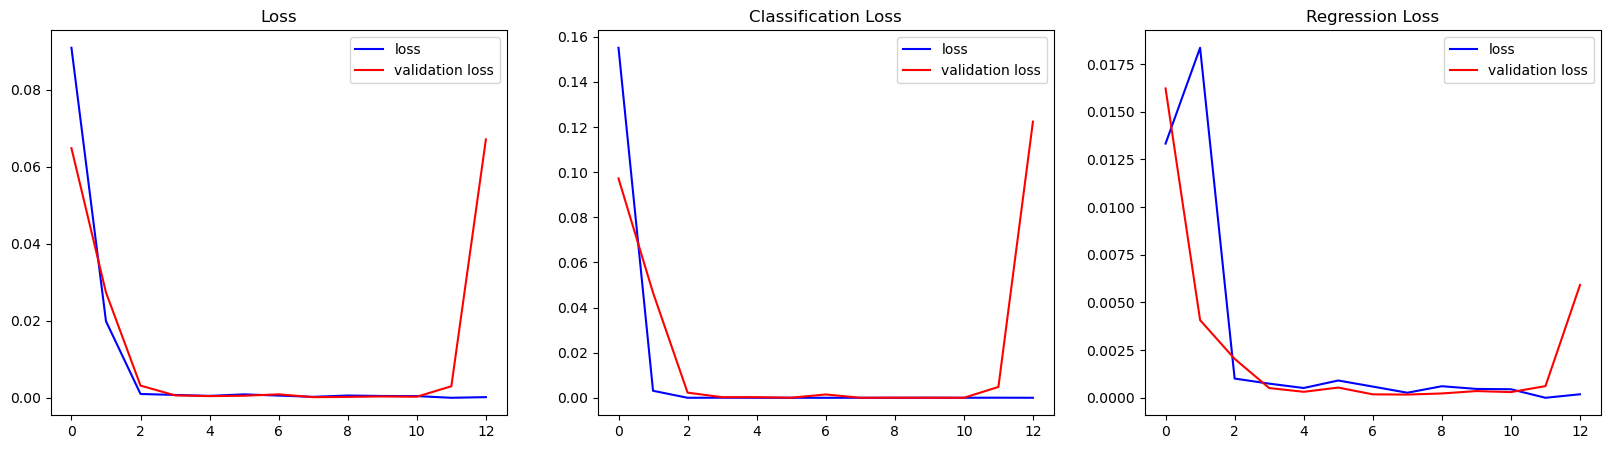

In [17]:
import matplotlib.pyplot as plt

plots = [
    ('total_loss', 'val_total_loss', 'Loss'),
    ('classification_loss', 'val_classification_loss', 'Classification Loss'),
    ('regression_loss', 'val_regression_loss', 'Regression Loss')
]

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

for i, (loss, val_loss, title) in enumerate(plots):
    ax[i].plot(history.history[loss], color='blue', label='loss')
    ax[i].plot(history.history[val_loss], color='red', label='validation loss')
    ax[i].title.set_text(title)
    ax[i].legend()
plt.show()

In [18]:
test_data = test_dataset.as_numpy_iterator()
test_sample = test_data.next()
y_pred = buddywatch.predict(test_sample[0])

1/1 [==============================] - 0s 361ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


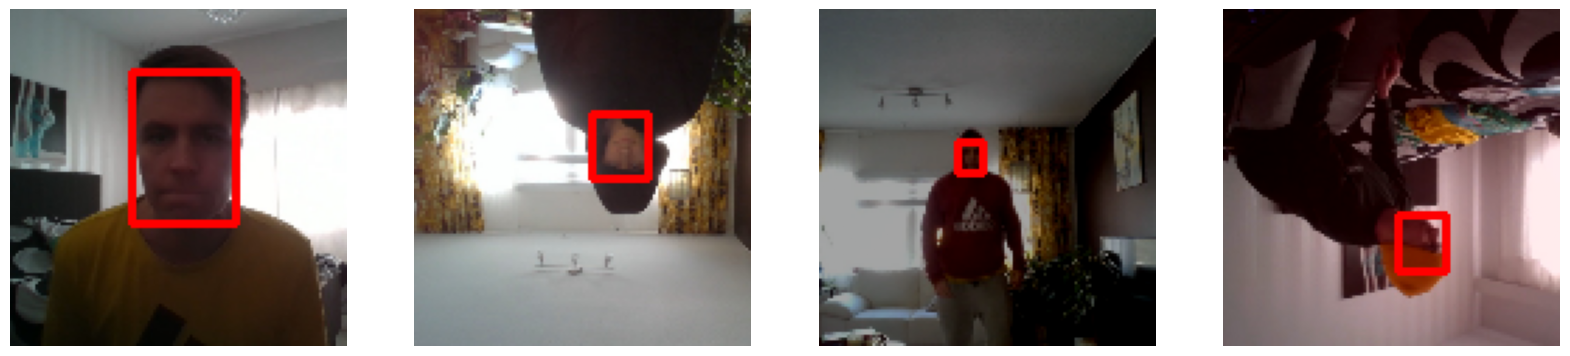

In [19]:
import cv2

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for i in range(4): 
    image = cv2.UMat(test_sample[0][i])
    bbox = y_pred[1][i]
    confidence = y_pred[0][i]
    
    if confidence > 0.9:
        bbox_start = tuple(np.multiply(bbox[:2], [120, 120]).astype(int))
        bbox_end = tuple(np.multiply(bbox[2:], [120, 120]).astype(int))
        cv2.rectangle(image, bbox_start, bbox_end, (255,0,0), 2)
        
    ax[i].axis('off')
    ax[i].imshow(np.asarray(image.get()))

In [20]:
buddywatch.save('buddywatch_face.h5')

In [21]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    if union == 0.0:
        return 0.0
    else:
        return intersection / union

In [22]:
iou_scores = []
for x, y in test_dataset:
    pred = model.predict(x)
    for pred_box, true_box in zip(pred[1], y[1]):
        iou = calculate_iou(pred_box, true_box)
        iou_scores.append(iou)

print("Average IoU: ", np.mean(iou_scores))

1/1 [==============================] - 1s 503ms/step
Average IoU:  0.5720470931475741
